In [69]:
from numpy.typing import NDArray, DTypeLike
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        self._params: list[NDArray] = []
        self._grad: list[NDArray] = []

    @abstractmethod
    def forward(self, x: NDArray) -> NDArray:
        pass

    @abstractmethod
    def backward(self, grad: NDArray) -> NDArray:
        pass


class MLP:
    eps = 1e-15
    beta = 0.9
    teta = 0.999
    elastic_ratio = 0.5
    elastic_lambda = 1e-4

    def __init__(
        self,
        input_size: int = 64,
        hidden_size: int = 32,
        output_size: int = 10,
        learning_rate: float = 1e-2
    ) -> None:
        self.sizes = [input_size, hidden_size, hidden_size, output_size]
        self.num_layers = len(self.sizes) - 1
        self.lr = learning_rate

        self.weights: list[NDArray] = [
            np.random.randn(self.sizes[i + 1], self.sizes[i]) * np.sqrt(2 / self.sizes[i])
            for i in range(self.num_layers)
        ]
        self.biases: list[NDArray] = [
            np.zeros((self.sizes[i + 1], 1))
            for i in range(self.num_layers)
        ]

        self.linears: list[NDArray] = []
        self.activations: list[NDArray] = []

        self.grads_w: list[NDArray] = [np.zeros_like(w) for w in self.weights]
        self.grads_b: list[NDArray] = [np.zeros_like(b) for b in self.biases]

        self.cache_w: list[NDArray] = [np.zeros_like(w) for w in self.weights]
        self.cache_b: list[NDArray] = [np.zeros_like(b) for b in self.biases]

        self.velocity_w: list[NDArray] = [np.zeros_like(w) for w in self.weights]
        self.velocity_b: list[NDArray] = [np.zeros_like(b) for b in self.biases]
        self.t = 0

    def forward(self, x: NDArray) -> NDArray:
        self.linears = []
        self.activations = [x]

        for i in range(self.num_layers):
            W, b = self.weights[i], self.biases[i]
            z = W @ x + b
            self.linears.append(z)
            x = self.relu(z) if i < self.num_layers - 1 else self.softmax(z)
            self.activations.append(x)

        return x

    # Linear Layer - y = Wx + b
    # delta it's dL/dy
    def backward_linear(self, delta: NDArray, i: int) -> NDArray:
        W, x = self.weights[i], self.activations[i]

        self.grads_w[i] = delta @ x.T
        # Regularization
        self.grads_w[i] += (MLP.elastic_lambda / x.shape[1]) * MLP.elastic_net_grad(W)

        self.grads_b[i] = np.sum(delta, axis=1, keepdims=True)
        next_delta = W.T @ delta

        return next_delta

    def backward_activation(self, delta: NDArray, i: int) -> NDArray:
        return delta * self.relu_derivative(self.linears[i])

    def backward(self, y_true: NDArray) -> None:
        # For softmax + cross-entropy, gradient at output = (y_pred - y_true) / m
        y_pred = self.activations[-1]
        delta = (y_pred - y_true) / y_true.shape[1]
        delta = self.backward_linear(delta, self.num_layers - 1)

        for i in range(self.num_layers - 2, -1, -1):
            delta = self.backward_activation(delta, i)
            delta = self.backward_linear(delta, i)

    def train(
        self,
        x: NDArray,
        y_true: NDArray,
        epochs: int = 100,
        verbose: bool = False
    ) -> list[float]:
        losses = []

        for epoch in range(1, epochs + 1):
            y_hat = self.forward(x)

            loss = self.cross_entropy(y_hat, y_true)
            for W in self.weights:
                loss += (MLP.elastic_lambda * MLP.elastic_net_penalty(W)) / x.shape[1]
            losses.append(loss)

            self.backward(y_true)

            self.sgd()

            if verbose and epoch % max(1, epochs // 10) == 0:
                print(f"Epoch {epoch}/{epochs} - loss: {loss:.6f}")

        return losses

    def sgd(self):
        for i in range(self.num_layers):
            self.weights[i] -= self.lr * self.grads_w[i]
            self.biases[i] -= self.lr * self.grads_b[i]

    # TODO
    # Add Batch Normalization With Scale and Shift
    # Add Class/Functions for batching
    # Realize Dropout
    # Data Augmentation
    # Add Skip Connection

    @staticmethod
    def l1_penalty(weights: NDArray) -> float:
        return np.sum(np.abs(weights))

    @staticmethod
    def l1_grad(weights: NDArray) -> NDArray:
        return np.sign(weights)

    @staticmethod
    def l2_penalty(weights: NDArray) -> float:
        return 0.5 * np.sum(weights ** 2)

    @staticmethod
    def l2_grad(weights: NDArray) -> NDArray:
        return weights

    @staticmethod
    def elastic_net_penalty(weights: NDArray) -> float:
        return MLP.elastic_ratio * MLP.l1_penalty(weights) + (1 - MLP.elastic_ratio) * MLP.l2_penalty(weights)

    @staticmethod
    def elastic_net_grad(weights: NDArray) -> NDArray:
        return MLP.elastic_ratio * MLP.l1_grad(weights) + (1 - MLP.elastic_ratio) * MLP.l2_grad(weights)

    def adam(self):
        self.t += 1
        for i in range(self.num_layers):
            # Update velocity and cache
            self.velocity_w[i] = MLP.beta * self.velocity_w[i] + (1 - MLP.beta) * self.grads_w[i]
            self.velocity_b[i] = MLP.beta * self.velocity_b[i] + (1 - MLP.beta) * self.grads_b[i]

            self.cache_w[i] = MLP.teta * self.cache_w[i] + (1 - MLP.teta) * self.grads_w[i] ** 2
            self.cache_b[i] = MLP.teta * self.cache_b[i] + (1 - MLP.teta) * self.grads_b[i] ** 2

            # Bias correction
            velocity_hat_w = self.velocity_w[i] / (1 - MLP.beta**self.t)
            velocity_hat_b = self.velocity_b[i] / (1 - MLP.beta**self.t)
            cache_hat_w = self.cache_w[i] / (1 - MLP.teta**self.t)
            cache_hat_b = self.cache_b[i] / (1 - MLP.teta**self.t)

            adjusted_lr_w = self.lr / (np.sqrt(cache_hat_w) + MLP.eps)
            adjusted_lr_b = self.lr / (np.sqrt(cache_hat_b) + MLP.eps)

            # Update weights and biases
            self.weights[i] -= adjusted_lr_w * velocity_hat_w
            self.biases[i] -= adjusted_lr_b * velocity_hat_b

    def rms_prop(self):
        for i in range(self.num_layers):
            self.cache_w[i] = MLP.beta * self.cache_w[i] + (1 - MLP.beta) * self.grads_w[i] ** 2
            self.cache_b[i] = MLP.beta * self.cache_b[i] + (1 - MLP.beta) * self.grads_b[i] ** 2

            adjusted_lr_w = self.lr / (np.sqrt(self.cache_w[i]) + MLP.eps)
            adjusted_lr_b = self.lr / (np.sqrt(self.cache_b[i]) + MLP.eps)

            self.weights[i] -= adjusted_lr_w * self.grads_w[i]
            self.biases[i] -= adjusted_lr_b * self.grads_b[i]

    def adagrad(self):
        for i in range(self.num_layers):
            self.cache_w[i] += self.grads_w[i] ** 2
            self.cache_b[i] += self.grads_b[i] ** 2

            adjusted_lr_w = self.lr / (np.sqrt(self.cache_w[i]) + MLP.eps)
            adjusted_lr_b = self.lr / (np.sqrt(self.cache_b[i]) + MLP.eps)

            self.weights[i] -= adjusted_lr_w * self.grads_w[i]
            self.biases[i] -= adjusted_lr_b * self.grads_b[i]

    @staticmethod
    def sigmoid(x: NDArray) -> NDArray:
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_derivative(x: NDArray) -> NDArray:
        s = MLP.sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def relu(x: NDArray) -> NDArray:
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x: NDArray) -> NDArray:
        return np.where(x > 0, 1, 0)

    @staticmethod
    def softmax(x: NDArray) -> NDArray:
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    @staticmethod
    def cross_entropy(y_hat: NDArray, y: NDArray) -> DTypeLike:
        # Add epsilon to avoid log(0)
        return -np.mean(np.sum(y * np.log(y_hat + MLP.eps), axis=0))

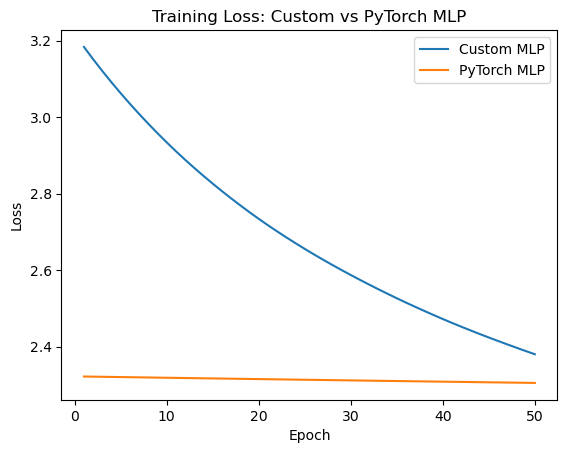

Custom MLP Loss: 2.379766666183537
Torch MLP Loss: 2.304733991622925


In [70]:
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import torch
import torch.nn as nn
import torch.optim as optim

class TorchMLP(nn.Module):
    def __init__(self, input_size=64, hidden_size=32, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )
    def forward(self, x):
        return self.net(x)

input_size, hidden_size, output_size = 64, 32, 10
batch_size = 128
epochs = 50

# numpy-данные
np.random.seed(42)
X_np = np.random.randn(input_size, batch_size)
Y_idx = np.random.randint(0, output_size, size=(batch_size,))
Y_onehot = np.eye(output_size)[:, Y_idx]

# torch-данные
X_torch = torch.tensor(X_np.T, dtype=torch.float32)
Y_torch = torch.tensor(Y_idx, dtype=torch.long)

# 4) Тренировка CustomMLP
custom = MLP(input_size, hidden_size, output_size, learning_rate=1e-2)
losses_custom = custom.train(X_np, Y_onehot, epochs=epochs)

# 5) Тренировка TorchMLP
torch_model = TorchMLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(torch_model.parameters(), lr=1e-2)
losses_torch = []
for _ in range(epochs):
    optimizer.zero_grad()
    outputs = torch_model(X_torch)
    loss = criterion(outputs, Y_torch)
    losses_torch.append(loss.item())
    loss.backward()
    optimizer.step()

# 6) Построение графика сравнения
plt.plot(range(1, epochs+1), losses_custom, label='Custom MLP')
plt.plot(range(1, epochs+1), losses_torch, label='PyTorch MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: Custom vs PyTorch MLP')
plt.legend()
plt.show()

print("Custom MLP Loss:", losses_custom[-1])
print("Torch MLP Loss:", losses_torch[-1])

In [3]:
torch.cuda.is_available()

False